# SKIN_TONE_DETECTOR_USING_MOBILENETV2

## IMPORT LIBRARY

In [8]:
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import csv
import ast
import cv2
import time
from collections import defaultdict 
from tensorflow.keras.models import load_model
import logging
import numpy
import math


In [9]:
np.random.seed(42)
tf.random.set_seed(42)

## PREPROCESS DATA

### EXTRACT FACE-ONLY IMAGE

In [11]:
import os
from mtcnn import MTCNN
import cv2

source_directory = 'public_test'
destination_directory = 'public_test_data'

os.makedirs(destination_directory, exist_ok=True)

mtcnn = MTCNN()

batch_size = 10  # Number of images to process in a batch

image_filenames = sorted([filename for filename in os.listdir(source_directory) if filename.lower().endswith(('.jpg', '.jpeg', '.png'))])

for batch_start in range(0, len(image_filenames), batch_size):
    batch_end = batch_start + batch_size
    batch_image_filenames = image_filenames[batch_start:batch_end]

    for image_filename in batch_image_filenames:
        image_path = os.path.join(source_directory, image_filename)
        image = cv2.imread(image_path)

        try:
            faces = mtcnn.detect_faces(image)
        except Exception as e:
            print(f"Error detecting faces in {image_filename}: {e}")
            continue  # Skip this image and move to the next

        if len(faces) > 0:
            largest_face = max(faces, key=lambda f: f['box'][2] * f['box'][3])
            x, y, w, h = largest_face['box']

            min_face_size = 50
            if w > min_face_size and h > min_face_size:
                face = image[y:y+h, x:x+w]

                extracted_face_filename = f'{os.path.splitext(image_filename)[0]}_face.jpg'
                extracted_face_path = os.path.join(destination_directory, extracted_face_filename)

                cv2.imwrite(extracted_face_path, face)
            else:
                print(f"Face in {image_filename} is too small and will be skipped.")
        else:
            print(f"No face detected in {image_filename}.")

    print(f"Processed images {batch_start+1} to {min(batch_end, len(image_filenames))}.")

print("Face extraction complete.")


1/1 [==============================] - 1s 647ms/step
light
Not dark or mid-dark. Skipping.
1/1 [==============================] - 0s 64ms/step
light
Not dark or mid-dark. Skipping.
1/1 [==============================] - 0s 49ms/step
No face detected in 100473997.jpg.
1/1 [==============================] - 0s 59ms/step
light
Not dark or mid-dark. Skipping.
1/1 [==============================] - 0s 25ms/step
No face detected in 101013830.jpg.
1/1 [==============================] - 0s 45ms/step
Face in 101347438.jpg is too small and will be skipped.
1/1 [==============================] - 0s 96ms/step
light
Not dark or mid-dark. Skipping.
1/1 [==============================] - 0s 59ms/step
No face detected in 102495577.jpg.
1/1 [==============================] - 0s 37ms/step
No face detected in 102800204.jpg.
1/1 [==============================] - 0s 68ms/step
light
Not dark or mid-dark. Skipping.
Processed images 1 to 10.
1/1 [==============================] - 0s 70ms/step
light
Not dark 

KeyboardInterrupt: 

### MAP LABEL 

In [10]:
def create_map_from_csv(file_path, image_data):
    label_map = {}
    bbox_map = {}

    with open(file_path, 'r') as csv_file:
        csv_reader = csv.reader(csv_file)
        next(csv_reader)  # Skip the header

        for row in csv_reader:
            if len(row) >= 4:  # Đảm bảo có ít nhất 4 giá trị trên hàng
                key = row[0]
                label = row[-3]
                bbox = ast.literal_eval(row[3])  # Convert string to tuple
                label_map[key] = label
                bbox_map[key] = tuple(bbox)
                image_data.append(key)

    return label_map, bbox_map

In [11]:
csv_file_path = "D:\Code\BachKhoa\AI Hackathon\labels.csv"
image_data = []
label_map, bbox_map = create_map_from_csv(csv_file_path, image_data)
image_data = image_data[1:]

print(image_data)
print(label_map)
print(bbox_map)

['100016175.jpg', '10004189.jpg', '100104575.jpg', '100104600.jpg', '100118748.jpg', '10012376.jpg', '100127351.jpg', '10015832.jpg', '10019527.jpg', '100217868.jpg', '100234133.jpg', '10024034.jpg', '100275687.jpg', '100290547.jpg', '100332639.jpg', '10035883.jpg', '100364120.jpg', '100375438.jpg', '100436471.jpg', '100446006.jpg', '100457349.jpg', '100497714.jpg', '100521368.jpg', '100537938.jpg', '100542719.jpg', '100616693.jpg', '100618366.jpg', '100620073.jpg', '10062392.jpg', '100689967.jpg', '100736316.jpg', '10074864.jpg', '10076105.jpg', '10079415.jpg', '100834752.jpg', '100867877.jpg', '100891652.jpg', '10097784.jpg', '10097785.jpg', '10097786.jpg', '101013857.jpg', '101031644.jpg', '10104198.jpg', '101045841.jpg', '101056763.jpg', '101093778.jpg', '101103861.jpg', '101114983.jpg', '10112033.jpg', '101123852.jpg', '101124001.jpg', '10114066.jpg', '10115185.jpg', '10115790.jpg', '10116354.jpg', '101178068.jpg', '101224128.jpg', '10122946.jpg', '10123220.jpg', '101237211.jpg', 

### EXTRACT SKIN 

In [24]:
def find_images(path, recursive=False, ignore=True):
    if os.path.isfile(path):
        yield path
    elif os.path.isdir(path):
        assert os.path.isdir(path), 'FileIO - get_images: Directory does not exist'
        assert isinstance(recursive, bool), 'FileIO - get_images: recursive must be a boolean variable'
        ext, result = ['png', 'jpg', 'jpeg'], []
        for path_a in os.listdir(path):
            path_a = path + '/' + path_a
            if os.path.isdir(path_a) and recursive:
                for path_b in find_images(path_a):
                    yield path_b
            check_a = path_a.split('.')[-1] in ext
            check_b = ignore or ('-' not in path_a.split('/')[-1])
            if check_a and check_b:
                yield path_a
    else:
        raise ValueError('error! path is not a valid path or directory')


def display(title, img, max_size=200000):
    assert isinstance(img, numpy.ndarray), 'img must be a numpy array'
    assert isinstance(title, str), 'title must be a string'
    scale = numpy.sqrt(min(1.0, float(max_size) / (img.shape[0] * img.shape[1])))
    shape = (int(scale * img.shape[1]), int(scale * img.shape[0]))
    img = cv2.resize(img, shape)
    cv2.imshow(title, img)
    
    

logger = logging.getLogger('main')


def get_hsv_mask(img, debug=False):
    assert isinstance(img, numpy.ndarray), 'image must be a numpy array'
    assert img.ndim == 3, 'skin detection can only work on color images'
    logger.debug('getting hsv mask')

    lower_thresh = numpy.array([0, 50, 0], dtype=numpy.uint8)
    upper_thresh = numpy.array([120, 150, 255], dtype=numpy.uint8)
    img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    msk_hsv = cv2.inRange(img_hsv, lower_thresh, upper_thresh)

    msk_hsv[msk_hsv < 128] = 0
    msk_hsv[msk_hsv >= 128] = 1

    if debug:
        display('input', img)
        display('mask_hsv', msk_hsv)

    return msk_hsv.astype(float)


def get_rgb_mask(img, debug=False):
    assert isinstance(img, numpy.ndarray), 'image must be a numpy array'
    assert img.ndim == 3, 'skin detection can only work on color images'
    logger.debug('getting rgb mask')

    lower_thresh = numpy.array([45, 52, 108], dtype=numpy.uint8)
    upper_thresh = numpy.array([255, 255, 255], dtype=numpy.uint8)

    mask_a = cv2.inRange(img, lower_thresh, upper_thresh)
    mask_b = 255 * ((img[:, :, 2] - img[:, :, 1]) / 20)
    mask_c = 255 * ((numpy.max(img, axis=2) - numpy.min(img, axis=2)) / 20)
    # msk_rgb = cv2.bitwise_and(mask_c, cv2.bitwise_and(mask_a, mask_b))
    mask_d = numpy.bitwise_and(numpy.uint64(mask_a), numpy.uint64(mask_b))
    msk_rgb = numpy.bitwise_and(numpy.uint64(mask_c), numpy.uint64(mask_d))

    msk_rgb[msk_rgb < 128] = 0
    msk_rgb[msk_rgb >= 128] = 1

    if debug:
        display('input', img)
        display('mask_rgb', msk_rgb)

    return msk_rgb.astype(float)


def get_ycrcb_mask(img, debug=False):
    assert isinstance(img, numpy.ndarray), 'image must be a numpy array'
    assert img.ndim == 3, 'skin detection can only work on color images'
    logger.debug('getting ycrcb mask')

    lower_thresh = numpy.array([90, 100, 130], dtype=numpy.uint8)
    upper_thresh = numpy.array([230, 120, 180], dtype=numpy.uint8)

    img_ycrcb = cv2.cvtColor(img, cv2.COLOR_RGB2YCR_CB)
    msk_ycrcb = cv2.inRange(img_ycrcb, lower_thresh, upper_thresh)

    msk_ycrcb[msk_ycrcb < 128] = 0
    msk_ycrcb[msk_ycrcb >= 128] = 1

    if debug:
        display('input', img)
        display('mask_ycrcb', msk_ycrcb)

    return msk_ycrcb.astype(float)


def grab_cut_mask(img_col, mask, debug=False):
    assert isinstance(img_col, numpy.ndarray), 'image must be a numpy array'
    assert isinstance(mask, numpy.ndarray), 'mask must be a numpy array'
    assert img_col.ndim == 3, 'skin detection can only work on color images'
    assert mask.ndim == 2, 'mask must be 2D'

    kernel = numpy.ones((50, 50), numpy.float32) / (50 * 50)
    dst = cv2.filter2D(mask, -1, kernel)
    dst[dst != 0] = 255
    free = numpy.array(cv2.bitwise_not(dst), dtype=numpy.uint8)

    if debug:
        display('not skin', free)
        display('grabcut input', mask)

    grab_mask = numpy.zeros(mask.shape, dtype=numpy.uint8)
    grab_mask[:, :] = 2
    grab_mask[mask == 255] = 1
    grab_mask[free == 255] = 0

    if numpy.unique(grab_mask).tolist() == [0, 1]:
        logger.debug('conducting grabcut')
        bgdModel = numpy.zeros((1, 65), numpy.float64)
        fgdModel = numpy.zeros((1, 65), numpy.float64)

        if img_col.size != 0:
            mask, bgdModel, fgdModel = cv2.grabCut(img_col, grab_mask, None, bgdModel, fgdModel, 5,
                                                   cv2.GC_INIT_WITH_MASK)
            mask = numpy.where((mask == 2) | (mask == 0), 0, 1).astype(numpy.uint8)
        else:
            logger.warning('img_col is empty')

    return mask


def closing(mask):
    assert isinstance(mask, numpy.ndarray), 'mask must be a numpy array'
    assert mask.ndim == 2, 'mask must be a greyscale image'
    logger.debug("closing mask of shape {0}".format(mask.shape))

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=2)

    return mask


def extract_skin(img, thresh=0.5, debug=False):
    assert isinstance(img, numpy.ndarray), 'image must be a numpy array'
    assert img.ndim == 3, 'skin detection can only work on color images'
    logger.debug("processing image of shape {0}".format(img.shape))

    mask_hsv = get_hsv_mask(img, debug=debug)
    mask_rgb = get_rgb_mask(img, debug=debug)
    mask_ycrcb = get_ycrcb_mask(img, debug=debug)
    
    n_masks = 3.0
    mask = (mask_hsv + mask_rgb + mask_ycrcb) / n_masks

    mask[mask < thresh] = 0.0
    mask[mask >= thresh] = 255.0
    logger.debug('{0}% of the image is skin'.format(int((100.0 / 255.0) * numpy.sum(mask) / mask.size)))

    mask = mask.astype(numpy.uint8)
    mask = closing(mask)
    mask = grab_cut_mask(img, mask, debug=debug)

    # Tạo một hình ảnh mới chỉ chứa phần da
    # Khởi tạo một hình ảnh trắng có cùng kích thước với ảnh gốc
    skin_only_image = np.zeros_like(img, np.uint8) + 255
    
    # Áp dụng mặt nạ để lấy phần da, bỏ qua phần còn lại
    for i in range(3):  # Lặp qua từng kênh màu
        skin_only_image[:, :, i] = cv2.bitwise_and(img[:, :, i], mask)

    return skin_only_image

def filter_out_black(image):
    # Tạo mặt nạ cho các pixel không phải màu đen
    mask = np.all(image != (0, 0, 0), axis=-1)

    # Tạo ảnh mới chứa các pixel không phải màu đen
    non_black_pixels = image[mask]
    if len(non_black_pixels) == 0 :
        return None
    new_height = int(math.sqrt(len(non_black_pixels)))
    new_width = new_height
    non_black_pixels = non_black_pixels[0:new_height*new_width]
    new_image = np.zeros((new_height, new_width, 3), dtype=np.uint8)
    new_image[:len(non_black_pixels) // new_width, :new_width] = non_black_pixels.reshape(-1, new_width, 3)
    return new_image

### CREATE SKIN-ONLY DATA

In [25]:
data_source_path = "D:\Code\BachKhoa\AI Hackathon\mnt\md0\projects\sami-hackathon\private\data"
data_destination_path = "data"

# Tạo các thư mục cho mỗi loại màu da nếu chúng chưa tồn tại
skin_tones = ['dark', 'mid-dark', 'mid-light', 'light']
for tone in skin_tones:
    os.makedirs(os.path.join(data_destination_path, tone), exist_ok=True)

for img in image_data:
    img_link = os.path.join(data_source_path, img)
    image = cv2.imread(img_link)
    bbox = bbox_map[img]
    x, y, w, h = [int(coord) for coord in bbox]
    image = image[y:y+h, x:x+w]
    # image = extract_skin(image)
    
    # image = filter_out_black(image)
    if image is not None:
        label = label_map[img]
        if label in skin_tones:
            # Lưu hình vào thư mục tương ứng
            save_path = os.path.join(data_destination_path, label, img)
            cv2.imwrite(save_path, image)

### INITIALIZE BASIC PARAMETERS FOR TRAINING

In [13]:
dataset_path = 'data'
input_shape = (90, 120, 3)
classes = ['dark', 'mid-dark', 'mid-light', 'light']
EPOCHS = 100  # Increase the number of epochs
BS = 32

data = []
labels = []

### PREPROCESS IMAGES

In [14]:
for idx, class_name in enumerate(classes):
    class_path = os.path.join(dataset_path, class_name)
    for filename in os.listdir(class_path):
        image_path = os.path.join(class_path, filename)
        image = tf.keras.preprocessing.image.load_img(image_path, target_size=input_shape[:2])
        image = tf.keras.preprocessing.image.img_to_array(image)
        image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
        data.append(image)
        labels.append(idx)

In [15]:
data = np.array(data, dtype="float32")
labels = np.array(labels)

### DIVIDE DATA INTO TRAIN_SET AND VALIDATION_SET

In [16]:
trainX, testX, trainY, testY = train_test_split(data, labels, test_size=0.2, stratify=labels, random_state=42)

### GENERATE DATA FOR TRAINING PROCESS

In [17]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

In [18]:
train_datagen = datagen.flow(trainX, trainY, batch_size=BS, shuffle=True)

## TRAIN MobileNetV2 MODEL

In [19]:
base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
base_model.trainable = False

In [20]:
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(len(classes), activation='softmax')
])

model.compile(optimizer=Adam(lr=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [21]:
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [22]:
history = model.fit(
    train_datagen,
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS,
    callbacks=[lr_scheduler, early_stopping]  # Add both callbacks
)

Epoch 1/100
374/374 [==============================] - ETA: 0s - loss: 0.7498 - accuracy: 0.6944WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 93 batches). You may need to use the repeat() function when building your dataset.


374/374 [==============================] - 136s 356ms/step - loss: 0.7498 - accuracy: 0.6944 - val_loss: 0.6704 - val_accuracy: 0.7147 - lr: 0.0010
Epoch 2/100
374/374 [==============================] - ETA: 0s - loss: 0.6518 - accuracy: 0.7180WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy,lr


374/374 [==============================] - 104s 277ms/step - loss: 0.6518 - accuracy: 0.7180 - lr: 0.0010
Epoch 3/100
374/374 [==============================] - ETA: 0s - loss: 0.6306 - accuracy: 0.7249WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy,lr


374/374 [==============================] - 81s 216ms/step - loss: 0.6306 - accuracy: 0.7249 - lr: 0.0010
Epoch 4/100
374/374 [==============================] - ETA: 0s - loss: 0.6229 - accuracy: 0.7327WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy,lr


374/374 [==============================] - 87s 231ms/step - loss: 0.6229 - accuracy: 0.7327 - lr: 0.0010
Epoch 5/100
374/374 [==============================] - ETA: 0s - loss: 0.6144 - accuracy: 0.7339WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy,lr


374/374 [==============================] - 85s 228ms/step - loss: 0.6144 - accuracy: 0.7339 - lr: 0.0010
Epoch 6/100
374/374 [==============================] - ETA: 0s - loss: 0.6131 - accuracy: 0.7338WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy,lr


374/374 [==============================] - 87s 231ms/step - loss: 0.6131 - accuracy: 0.7338 - lr: 0.0010
Epoch 7/100
374/374 [==============================] - ETA: 0s - loss: 0.6038 - accuracy: 0.7384WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy,lr


374/374 [==============================] - 82s 219ms/step - loss: 0.6038 - accuracy: 0.7384 - lr: 0.0010
Epoch 8/100
374/374 [==============================] - ETA: 0s - loss: 0.6024 - accuracy: 0.7406WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy,lr


374/374 [==============================] - 84s 224ms/step - loss: 0.6024 - accuracy: 0.7406 - lr: 0.0010
Epoch 9/100
374/374 [==============================] - ETA: 0s - loss: 0.5989 - accuracy: 0.7392WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy,lr


374/374 [==============================] - 75s 200ms/step - loss: 0.5989 - accuracy: 0.7392 - lr: 0.0010
Epoch 10/100
374/374 [==============================] - ETA: 0s - loss: 0.6013 - accuracy: 0.7428WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy,lr


374/374 [==============================] - 75s 201ms/step - loss: 0.6013 - accuracy: 0.7428 - lr: 0.0010
Epoch 11/100
374/374 [==============================] - ETA: 0s - loss: 0.5980 - accuracy: 0.7380WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy,lr


374/374 [==============================] - 80s 214ms/step - loss: 0.5980 - accuracy: 0.7380 - lr: 0.0010
Epoch 12/100
374/374 [==============================] - ETA: 0s - loss: 0.5974 - accuracy: 0.7442WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy,lr


374/374 [==============================] - 86s 229ms/step - loss: 0.5974 - accuracy: 0.7442 - lr: 0.0010
Epoch 13/100
374/374 [==============================] - ETA: 0s - loss: 0.5919 - accuracy: 0.7411WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy,lr


374/374 [==============================] - 77s 206ms/step - loss: 0.5919 - accuracy: 0.7411 - lr: 0.0010
Epoch 14/100
374/374 [==============================] - ETA: 0s - loss: 0.5935 - accuracy: 0.7420WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy,lr


374/374 [==============================] - 74s 197ms/step - loss: 0.5935 - accuracy: 0.7420 - lr: 0.0010
Epoch 15/100
374/374 [==============================] - ETA: 0s - loss: 0.5877 - accuracy: 0.7471WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy,lr


374/374 [==============================] - 73s 195ms/step - loss: 0.5877 - accuracy: 0.7471 - lr: 0.0010
Epoch 16/100
374/374 [==============================] - ETA: 0s - loss: 0.5881 - accuracy: 0.7438WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy,lr


374/374 [==============================] - 74s 197ms/step - loss: 0.5881 - accuracy: 0.7438 - lr: 0.0010
Epoch 17/100
374/374 [==============================] - ETA: 0s - loss: 0.5860 - accuracy: 0.7497WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy,lr


374/374 [==============================] - 73s 195ms/step - loss: 0.5860 - accuracy: 0.7497 - lr: 0.0010
Epoch 18/100
374/374 [==============================] - ETA: 0s - loss: 0.5792 - accuracy: 0.7460WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy,lr


374/374 [==============================] - 79s 211ms/step - loss: 0.5792 - accuracy: 0.7460 - lr: 0.0010
Epoch 19/100
374/374 [==============================] - ETA: 0s - loss: 0.5756 - accuracy: 0.7523WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy,lr


374/374 [==============================] - 77s 206ms/step - loss: 0.5756 - accuracy: 0.7523 - lr: 0.0010
Epoch 20/100
374/374 [==============================] - ETA: 0s - loss: 0.5751 - accuracy: 0.7531WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy,lr


374/374 [==============================] - 74s 198ms/step - loss: 0.5751 - accuracy: 0.7531 - lr: 0.0010
Epoch 21/100
374/374 [==============================] - ETA: 0s - loss: 0.5744 - accuracy: 0.7500WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy,lr


374/374 [==============================] - 73s 195ms/step - loss: 0.5744 - accuracy: 0.7500 - lr: 0.0010
Epoch 22/100
374/374 [==============================] - ETA: 0s - loss: 0.5797 - accuracy: 0.7494WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy,lr


374/374 [==============================] - 73s 195ms/step - loss: 0.5797 - accuracy: 0.7494 - lr: 0.0010
Epoch 23/100
374/374 [==============================] - ETA: 0s - loss: 0.5813 - accuracy: 0.7454WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy,lr


374/374 [==============================] - 74s 198ms/step - loss: 0.5813 - accuracy: 0.7454 - lr: 0.0010
Epoch 24/100
374/374 [==============================] - ETA: 0s - loss: 0.5764 - accuracy: 0.7505WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy,lr


374/374 [==============================] - 74s 198ms/step - loss: 0.5764 - accuracy: 0.7505 - lr: 0.0010
Epoch 25/100
374/374 [==============================] - ETA: 0s - loss: 0.5777 - accuracy: 0.7503WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy,lr


374/374 [==============================] - 73s 195ms/step - loss: 0.5777 - accuracy: 0.7503 - lr: 0.0010
Epoch 26/100
374/374 [==============================] - ETA: 0s - loss: 0.5811 - accuracy: 0.7501WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy,lr


374/374 [==============================] - 75s 199ms/step - loss: 0.5811 - accuracy: 0.7501 - lr: 0.0010
Epoch 27/100
374/374 [==============================] - ETA: 0s - loss: 0.5768 - accuracy: 0.7574WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy,lr


374/374 [==============================] - 75s 200ms/step - loss: 0.5768 - accuracy: 0.7574 - lr: 0.0010
Epoch 28/100
374/374 [==============================] - ETA: 0s - loss: 0.5734 - accuracy: 0.7537WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy,lr


374/374 [==============================] - 73s 195ms/step - loss: 0.5734 - accuracy: 0.7537 - lr: 0.0010
Epoch 29/100
374/374 [==============================] - ETA: 0s - loss: 0.5714 - accuracy: 0.7516WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy,lr


374/374 [==============================] - 280s 750ms/step - loss: 0.5714 - accuracy: 0.7516 - lr: 0.0010
Epoch 30/100
374/374 [==============================] - ETA: 0s - loss: 0.5736 - accuracy: 0.7495WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy,lr


374/374 [==============================] - 96s 256ms/step - loss: 0.5736 - accuracy: 0.7495 - lr: 0.0010
Epoch 31/100
374/374 [==============================] - ETA: 0s - loss: 0.5720 - accuracy: 0.7502WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy,lr


374/374 [==============================] - 94s 252ms/step - loss: 0.5720 - accuracy: 0.7502 - lr: 0.0010
Epoch 32/100
374/374 [==============================] - ETA: 0s - loss: 0.5696 - accuracy: 0.7506WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy,lr


374/374 [==============================] - 95s 254ms/step - loss: 0.5696 - accuracy: 0.7506 - lr: 0.0010
Epoch 33/100
374/374 [==============================] - ETA: 0s - loss: 0.5728 - accuracy: 0.7536WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy,lr


374/374 [==============================] - 93s 249ms/step - loss: 0.5728 - accuracy: 0.7536 - lr: 0.0010
Epoch 34/100
374/374 [==============================] - ETA: 0s - loss: 0.5636 - accuracy: 0.7546WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy,lr


374/374 [==============================] - 91s 244ms/step - loss: 0.5636 - accuracy: 0.7546 - lr: 0.0010
Epoch 35/100
374/374 [==============================] - ETA: 0s - loss: 0.5613 - accuracy: 0.7513WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy,lr


374/374 [==============================] - 86s 229ms/step - loss: 0.5613 - accuracy: 0.7513 - lr: 0.0010
Epoch 36/100
374/374 [==============================] - ETA: 0s - loss: 0.5687 - accuracy: 0.7522WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy,lr


374/374 [==============================] - 90s 240ms/step - loss: 0.5687 - accuracy: 0.7522 - lr: 0.0010
Epoch 37/100
374/374 [==============================] - ETA: 0s - loss: 0.5642 - accuracy: 0.7556WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy,lr


374/374 [==============================] - 94s 250ms/step - loss: 0.5642 - accuracy: 0.7556 - lr: 0.0010
Epoch 38/100
374/374 [==============================] - ETA: 0s - loss: 0.5568 - accuracy: 0.7578WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy,lr


374/374 [==============================] - 86s 229ms/step - loss: 0.5568 - accuracy: 0.7578 - lr: 0.0010
Epoch 39/100
374/374 [==============================] - ETA: 0s - loss: 0.5642 - accuracy: 0.7586WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy,lr


374/374 [==============================] - 90s 241ms/step - loss: 0.5642 - accuracy: 0.7586 - lr: 0.0010
Epoch 40/100
374/374 [==============================] - ETA: 0s - loss: 0.5635 - accuracy: 0.7557WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy,lr


374/374 [==============================] - 81s 215ms/step - loss: 0.5635 - accuracy: 0.7557 - lr: 0.0010
Epoch 41/100
374/374 [==============================] - ETA: 0s - loss: 0.5605 - accuracy: 0.7547WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy,lr


374/374 [==============================] - 81s 215ms/step - loss: 0.5605 - accuracy: 0.7547 - lr: 0.0010
Epoch 42/100
374/374 [==============================] - ETA: 0s - loss: 0.5634 - accuracy: 0.7603WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy,lr


374/374 [==============================] - 102s 272ms/step - loss: 0.5634 - accuracy: 0.7603 - lr: 0.0010
Epoch 43/100
374/374 [==============================] - ETA: 0s - loss: 0.5654 - accuracy: 0.7608WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy,lr


374/374 [==============================] - 113s 301ms/step - loss: 0.5654 - accuracy: 0.7608 - lr: 0.0010
Epoch 44/100
374/374 [==============================] - ETA: 0s - loss: 0.5578 - accuracy: 0.7631WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy,lr


374/374 [==============================] - 127s 339ms/step - loss: 0.5578 - accuracy: 0.7631 - lr: 0.0010
Epoch 45/100
374/374 [==============================] - ETA: 0s - loss: 0.5505 - accuracy: 0.7639WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy,lr


374/374 [==============================] - 107s 286ms/step - loss: 0.5505 - accuracy: 0.7639 - lr: 0.0010
Epoch 46/100
374/374 [==============================] - ETA: 0s - loss: 0.5565 - accuracy: 0.7574WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy,lr


374/374 [==============================] - 119s 318ms/step - loss: 0.5565 - accuracy: 0.7574 - lr: 0.0010
Epoch 47/100
374/374 [==============================] - ETA: 0s - loss: 0.5599 - accuracy: 0.7564WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy,lr


374/374 [==============================] - 93s 250ms/step - loss: 0.5599 - accuracy: 0.7564 - lr: 0.0010
Epoch 48/100
374/374 [==============================] - ETA: 0s - loss: 0.5546 - accuracy: 0.7582WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy,lr


374/374 [==============================] - 100s 266ms/step - loss: 0.5546 - accuracy: 0.7582 - lr: 0.0010
Epoch 49/100
374/374 [==============================] - ETA: 0s - loss: 0.5545 - accuracy: 0.7654WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy,lr


374/374 [==============================] - 97s 259ms/step - loss: 0.5545 - accuracy: 0.7654 - lr: 0.0010
Epoch 50/100
374/374 [==============================] - ETA: 0s - loss: 0.5582 - accuracy: 0.7577WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy,lr


374/374 [==============================] - 88s 234ms/step - loss: 0.5582 - accuracy: 0.7577 - lr: 0.0010
Epoch 51/100
374/374 [==============================] - ETA: 0s - loss: 0.5503 - accuracy: 0.7614WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy,lr


374/374 [==============================] - 96s 255ms/step - loss: 0.5503 - accuracy: 0.7614 - lr: 0.0010
Epoch 52/100
374/374 [==============================] - ETA: 0s - loss: 0.5592 - accuracy: 0.7576WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy,lr


374/374 [==============================] - 98s 262ms/step - loss: 0.5592 - accuracy: 0.7576 - lr: 0.0010
Epoch 53/100
374/374 [==============================] - ETA: 0s - loss: 0.5496 - accuracy: 0.7598WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy,lr


374/374 [==============================] - 91s 243ms/step - loss: 0.5496 - accuracy: 0.7598 - lr: 0.0010
Epoch 54/100
374/374 [==============================] - ETA: 0s - loss: 0.5535 - accuracy: 0.7608WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy,lr


374/374 [==============================] - 86s 229ms/step - loss: 0.5535 - accuracy: 0.7608 - lr: 0.0010
Epoch 55/100
374/374 [==============================] - ETA: 0s - loss: 0.5518 - accuracy: 0.7635WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy,lr


374/374 [==============================] - 104s 278ms/step - loss: 0.5518 - accuracy: 0.7635 - lr: 0.0010
Epoch 56/100
374/374 [==============================] - ETA: 0s - loss: 0.5493 - accuracy: 0.7623WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy,lr


374/374 [==============================] - 98s 263ms/step - loss: 0.5493 - accuracy: 0.7623 - lr: 0.0010
Epoch 57/100
374/374 [==============================] - ETA: 0s - loss: 0.5513 - accuracy: 0.7598WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy,lr


374/374 [==============================] - 95s 254ms/step - loss: 0.5513 - accuracy: 0.7598 - lr: 0.0010
Epoch 58/100
374/374 [==============================] - ETA: 0s - loss: 0.5553 - accuracy: 0.7613WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy,lr


374/374 [==============================] - 79s 210ms/step - loss: 0.5553 - accuracy: 0.7613 - lr: 0.0010
Epoch 59/100
374/374 [==============================] - ETA: 0s - loss: 0.5512 - accuracy: 0.7623WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy,lr


374/374 [==============================] - 89s 238ms/step - loss: 0.5512 - accuracy: 0.7623 - lr: 0.0010
Epoch 60/100
374/374 [==============================] - ETA: 0s - loss: 0.5498 - accuracy: 0.7613WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy,lr


374/374 [==============================] - 95s 255ms/step - loss: 0.5498 - accuracy: 0.7613 - lr: 0.0010
Epoch 61/100
374/374 [==============================] - ETA: 0s - loss: 0.5555 - accuracy: 0.7607WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy,lr


374/374 [==============================] - 91s 243ms/step - loss: 0.5555 - accuracy: 0.7607 - lr: 0.0010
Epoch 62/100
374/374 [==============================] - ETA: 0s - loss: 0.5495 - accuracy: 0.7620WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy,lr


374/374 [==============================] - 98s 261ms/step - loss: 0.5495 - accuracy: 0.7620 - lr: 0.0010
Epoch 63/100
374/374 [==============================] - ETA: 0s - loss: 0.5535 - accuracy: 0.7591WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy,lr


374/374 [==============================] - 102s 272ms/step - loss: 0.5535 - accuracy: 0.7591 - lr: 0.0010
Epoch 64/100
374/374 [==============================] - ETA: 0s - loss: 0.5471 - accuracy: 0.7654WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy,lr


374/374 [==============================] - 93s 249ms/step - loss: 0.5471 - accuracy: 0.7654 - lr: 0.0010
Epoch 65/100
374/374 [==============================] - ETA: 0s - loss: 0.5450 - accuracy: 0.7580WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy,lr


374/374 [==============================] - 97s 259ms/step - loss: 0.5450 - accuracy: 0.7580 - lr: 0.0010
Epoch 66/100
374/374 [==============================] - ETA: 0s - loss: 0.5430 - accuracy: 0.7637WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy,lr


374/374 [==============================] - 90s 240ms/step - loss: 0.5430 - accuracy: 0.7637 - lr: 0.0010
Epoch 67/100
374/374 [==============================] - ETA: 0s - loss: 0.5434 - accuracy: 0.7639WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy,lr


374/374 [==============================] - 92s 246ms/step - loss: 0.5434 - accuracy: 0.7639 - lr: 0.0010
Epoch 68/100
374/374 [==============================] - ETA: 0s - loss: 0.5470 - accuracy: 0.7675WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy,lr


374/374 [==============================] - 90s 240ms/step - loss: 0.5470 - accuracy: 0.7675 - lr: 0.0010
Epoch 69/100
374/374 [==============================] - ETA: 0s - loss: 0.5471 - accuracy: 0.7625WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy,lr


374/374 [==============================] - 87s 232ms/step - loss: 0.5471 - accuracy: 0.7625 - lr: 0.0010
Epoch 70/100
374/374 [==============================] - ETA: 0s - loss: 0.5399 - accuracy: 0.7650WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy,lr


374/374 [==============================] - 82s 218ms/step - loss: 0.5399 - accuracy: 0.7650 - lr: 0.0010
Epoch 71/100
374/374 [==============================] - ETA: 0s - loss: 0.5436 - accuracy: 0.7698WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy,lr


374/374 [==============================] - 80s 215ms/step - loss: 0.5436 - accuracy: 0.7698 - lr: 0.0010
Epoch 72/100
374/374 [==============================] - ETA: 0s - loss: 0.5369 - accuracy: 0.7674WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy,lr


374/374 [==============================] - 81s 216ms/step - loss: 0.5369 - accuracy: 0.7674 - lr: 0.0010
Epoch 73/100
374/374 [==============================] - ETA: 0s - loss: 0.5419 - accuracy: 0.7652WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy,lr


374/374 [==============================] - 81s 216ms/step - loss: 0.5419 - accuracy: 0.7652 - lr: 0.0010
Epoch 74/100
374/374 [==============================] - ETA: 0s - loss: 0.5471 - accuracy: 0.7656WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy,lr


374/374 [==============================] - 81s 216ms/step - loss: 0.5471 - accuracy: 0.7656 - lr: 0.0010
Epoch 75/100
374/374 [==============================] - ETA: 0s - loss: 0.5438 - accuracy: 0.7657WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy,lr


374/374 [==============================] - 82s 218ms/step - loss: 0.5438 - accuracy: 0.7657 - lr: 0.0010
Epoch 76/100
374/374 [==============================] - ETA: 0s - loss: 0.5348 - accuracy: 0.7707WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy,lr


374/374 [==============================] - 81s 217ms/step - loss: 0.5348 - accuracy: 0.7707 - lr: 0.0010
Epoch 77/100
374/374 [==============================] - ETA: 0s - loss: 0.5445 - accuracy: 0.7644WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy,lr


374/374 [==============================] - 81s 215ms/step - loss: 0.5445 - accuracy: 0.7644 - lr: 0.0010
Epoch 78/100
374/374 [==============================] - ETA: 0s - loss: 0.5484 - accuracy: 0.7672WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy,lr


374/374 [==============================] - 81s 217ms/step - loss: 0.5484 - accuracy: 0.7672 - lr: 0.0010
Epoch 79/100
374/374 [==============================] - ETA: 0s - loss: 0.5418 - accuracy: 0.7662WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy,lr


374/374 [==============================] - 81s 218ms/step - loss: 0.5418 - accuracy: 0.7662 - lr: 0.0010
Epoch 80/100
374/374 [==============================] - ETA: 0s - loss: 0.5416 - accuracy: 0.7705WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy,lr


374/374 [==============================] - 84s 223ms/step - loss: 0.5416 - accuracy: 0.7705 - lr: 0.0010
Epoch 81/100
374/374 [==============================] - ETA: 0s - loss: 0.5412 - accuracy: 0.7695WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy,lr


374/374 [==============================] - 86s 230ms/step - loss: 0.5412 - accuracy: 0.7695 - lr: 0.0010
Epoch 82/100
374/374 [==============================] - ETA: 0s - loss: 0.5423 - accuracy: 0.7659WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy,lr


374/374 [==============================] - 83s 222ms/step - loss: 0.5423 - accuracy: 0.7659 - lr: 0.0010
Epoch 83/100
374/374 [==============================] - ETA: 0s - loss: 0.5435 - accuracy: 0.7648WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy,lr


374/374 [==============================] - 87s 233ms/step - loss: 0.5435 - accuracy: 0.7648 - lr: 0.0010
Epoch 84/100
374/374 [==============================] - ETA: 0s - loss: 0.5416 - accuracy: 0.7684WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy,lr


374/374 [==============================] - 92s 246ms/step - loss: 0.5416 - accuracy: 0.7684 - lr: 0.0010
Epoch 85/100
374/374 [==============================] - ETA: 0s - loss: 0.5398 - accuracy: 0.7633WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy,lr


374/374 [==============================] - 96s 257ms/step - loss: 0.5398 - accuracy: 0.7633 - lr: 0.0010
Epoch 86/100
374/374 [==============================] - ETA: 0s - loss: 0.5447 - accuracy: 0.7650WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy,lr


374/374 [==============================] - 81s 217ms/step - loss: 0.5447 - accuracy: 0.7650 - lr: 0.0010
Epoch 87/100
374/374 [==============================] - ETA: 0s - loss: 0.5411 - accuracy: 0.7659WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy,lr


374/374 [==============================] - 73s 196ms/step - loss: 0.5411 - accuracy: 0.7659 - lr: 0.0010
Epoch 88/100
374/374 [==============================] - ETA: 0s - loss: 0.5421 - accuracy: 0.7679WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy,lr


374/374 [==============================] - 76s 203ms/step - loss: 0.5421 - accuracy: 0.7679 - lr: 0.0010
Epoch 89/100
374/374 [==============================] - ETA: 0s - loss: 0.5437 - accuracy: 0.7652WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy,lr


374/374 [==============================] - 76s 202ms/step - loss: 0.5437 - accuracy: 0.7652 - lr: 0.0010
Epoch 90/100
374/374 [==============================] - ETA: 0s - loss: 0.5415 - accuracy: 0.7658WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy,lr


374/374 [==============================] - 78s 209ms/step - loss: 0.5415 - accuracy: 0.7658 - lr: 0.0010
Epoch 91/100
374/374 [==============================] - ETA: 0s - loss: 0.5346 - accuracy: 0.7698WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy,lr


374/374 [==============================] - 76s 203ms/step - loss: 0.5346 - accuracy: 0.7698 - lr: 0.0010
Epoch 92/100
374/374 [==============================] - ETA: 0s - loss: 0.5387 - accuracy: 0.7677WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy,lr


374/374 [==============================] - 76s 202ms/step - loss: 0.5387 - accuracy: 0.7677 - lr: 0.0010
Epoch 93/100
374/374 [==============================] - ETA: 0s - loss: 0.5318 - accuracy: 0.7646WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy,lr


374/374 [==============================] - 79s 210ms/step - loss: 0.5318 - accuracy: 0.7646 - lr: 0.0010
Epoch 94/100
374/374 [==============================] - ETA: 0s - loss: 0.5257 - accuracy: 0.7736WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy,lr


374/374 [==============================] - 77s 205ms/step - loss: 0.5257 - accuracy: 0.7736 - lr: 0.0010
Epoch 95/100
374/374 [==============================] - ETA: 0s - loss: 0.5306 - accuracy: 0.7710WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy,lr


374/374 [==============================] - 77s 206ms/step - loss: 0.5306 - accuracy: 0.7710 - lr: 0.0010
Epoch 96/100
374/374 [==============================] - ETA: 0s - loss: 0.5350 - accuracy: 0.7715WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy,lr


374/374 [==============================] - 78s 209ms/step - loss: 0.5350 - accuracy: 0.7715 - lr: 0.0010
Epoch 97/100
374/374 [==============================] - ETA: 0s - loss: 0.5377 - accuracy: 0.7715WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy,lr


374/374 [==============================] - 79s 210ms/step - loss: 0.5377 - accuracy: 0.7715 - lr: 0.0010
Epoch 98/100
374/374 [==============================] - ETA: 0s - loss: 0.5336 - accuracy: 0.7670WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy,lr


374/374 [==============================] - 80s 214ms/step - loss: 0.5336 - accuracy: 0.7670 - lr: 0.0010
Epoch 99/100
374/374 [==============================] - ETA: 0s - loss: 0.5321 - accuracy: 0.7707WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy,lr


374/374 [==============================] - 73s 195ms/step - loss: 0.5321 - accuracy: 0.7707 - lr: 0.0010
Epoch 100/100
374/374 [==============================] - ETA: 0s - loss: 0.5352 - accuracy: 0.7710WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy,lr


374/374 [==============================] - 73s 195ms/step - loss: 0.5352 - accuracy: 0.7710 - lr: 0.0010


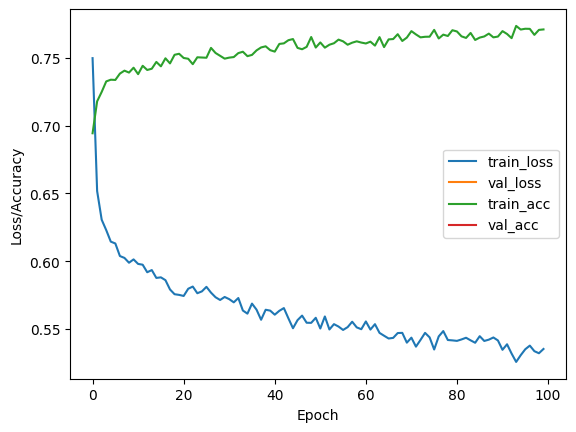

In [23]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
plt.show()

In [24]:
preds = model.predict(testX)
y_pred = np.argmax(preds, axis=1)

cm = confusion_matrix(testY, y_pred)
print("Confusion Matrix:")
print(cm)

print("Classification Report:")
print(classification_report(testY, y_pred, target_names=classes))

94/94 [==============================] - 17s 163ms/step
Confusion Matrix:
[[  24   17   22    3]
 [  10   26   80   32]
 [   2   10  228  485]
 [   2    3   88 1968]]
Classification Report:
              precision    recall  f1-score   support

        dark       0.63      0.36      0.46        66
    mid-dark       0.46      0.18      0.25       148
   mid-light       0.55      0.31      0.40       725
       light       0.79      0.95      0.87      2061

    accuracy                           0.75      3000
   macro avg       0.61      0.45      0.50      3000
weighted avg       0.71      0.75      0.71      3000



In [25]:
model.save('skin_tone_100_epoch_model.h5')
print("Model saved.")

c:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved.


## VALIDATE MODEL BASED ON REAL DATA


In [27]:
start = time.time()
diffusion_matrix = defaultdict(lambda: defaultdict(lambda: 0))
model = load_model('skin_tone_100_epoch_model.h5')  # Replace with your model path
count = 0
data_source_path = "D:\Code\BachKhoa\AI Hackathon\mnt\md0\projects\sami-hackathon\private\data"
classes = ['dark', 'mid-dark', 'mid-light', 'light']

for img in image_data:
    img_link = os.path.join(data_source_path, img)
    image = cv2.imread(img_link)
    bbox = bbox_map[img]
    x, y, w, h = [int(coord) for coord in bbox]
    detected_face = image[y:y+h, x:x+w]
    # detected_face = extract_skin(detected_face)

    detected_face = cv2.resize(detected_face, (120, 90))
    detected_face = tf.keras.applications.mobilenet_v2.preprocess_input(detected_face[np.newaxis, ...])
    
    predictions = model.predict(detected_face)
    predicted_class_idx = np.argmax(predictions)
    predicted_class = classes[predicted_class_idx]
    
    count+=1
    if count==(3000):
        break
    
    diffusion_matrix[label_map[img]][predicted_class]+=1

    print(f"\033[91mImage: {img}. PREDICT: {predicted_class}. LABEL: {label_map[img]}. COUNT: {count}\033[0m")
    print(f"Accuracy: {(diffusion_matrix['dark']['dark'] + diffusion_matrix['mid-dark']['mid-dark'] + diffusion_matrix['mid-light']['mid-light'] + diffusion_matrix['light']['light']) / count}")
        

    
    print(f"{'':<10}{'Dark':<10}{'Mid-Dark':<10}{'Mid-Light':<10}{'Light':<10}")
    print(f"{'Dark':<10}{diffusion_matrix['dark']['dark']:<10}{diffusion_matrix['dark']['mid-dark']:<10}{diffusion_matrix['dark']['mid-light']:<10}{diffusion_matrix['dark']['light']:<10}")
    print(f"{'Mid-Dark':<10}{diffusion_matrix['mid-dark']['dark']:<10}{diffusion_matrix['mid-dark']['mid-dark']:<10}{diffusion_matrix['mid-dark']['mid-light']:<10}{diffusion_matrix['mid-dark']['light']:<10}")
    print(f"{'Mid-Light':<10}{diffusion_matrix['mid-light']['dark']:<10}{diffusion_matrix['mid-light']['mid-dark']:<10}{diffusion_matrix['mid-light']['mid-light']:<10}{diffusion_matrix['mid-light']['light']:<10}")
    print(f"{'Light':<10}{diffusion_matrix['light']['dark']:<10}{diffusion_matrix['light']['mid-dark']:<10}{diffusion_matrix['light']['mid-light']:<10}{diffusion_matrix['light']['light']:<10}")
    print(f"Accuracy: {(diffusion_matrix['dark']['dark'] + diffusion_matrix['mid-dark']['mid-dark'] + diffusion_matrix['mid-light']['mid-light'] + diffusion_matrix['light']['light']) / count}. COUNT: {count}")

finish = time.time()
print(f"Time: {finish - start}")

1/1 [==============================] - 1s 682ms/step
Image: 100016175.jpg. PREDICT: light. LABEL: light. COUNT: 1
Accuracy: 1.0
          Dark      Mid-Dark  Mid-Light Light     
Dark      0         0         0         0         
Mid-Dark  0         0         0         0         
Mid-Light 0         0         0         0         
Light     0         0         0         1         
Accuracy: 1.0. COUNT: 1
1/1 [==============================] - 0s 45ms/step
Image: 10004189.jpg. PREDICT: light. LABEL: light. COUNT: 2
Accuracy: 1.0
          Dark      Mid-Dark  Mid-Light Light     
Dark      0         0         0         0         
Mid-Dark  0         0         0         0         
Mid-Light 0         0         0         0         
Light     0         0         0         2         
Accuracy: 1.0. COUNT: 2
1/1 [==============================] - 0s 42ms/step
Image: 100104575.jpg. PREDICT: mid-dark. LABEL: mid-light. COUNT: 3
Accuracy: 0.6666666666666666
          Dark      Mid-Dark  Mid-Light